# Overview

Congratulations! You have reached the end of the CS 190 curriculum. As a final summative exercise, you will be tasked to develop a model to detect pulmonary infection (pneumonia) on chest radiographs using any of the approaches and tools you have learned this quarter. The brief tutorial will simply introduce the dataset and configuration of the Python generators prepared for this exercise. In addition, I will provide some hints and suggestions for how to build the best possible network using this data. Once you are familiar with the task, you are welcome to move onto the assignment which contains more details regarding algorithm design requirements and submission.

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Mount Google Drive

The Google Colab environment is transient and will reset after any prolonged break in activity. To retain important and/or large files between sessions, use the following lines of code to mount your personal Google drive to this Colab instance:

In [ ]:
try:
    # --- Mount gdrive to /content/drive/My Drive/
    from google.colab import drive
    drive.mount('/content/drive')
    
except: pass

**Important note**: it is not required to mount your Google Drive locally to run this tutorial. This is only required if you wish to save any trained model files or outputs. If you choose to skip this step, all remaining code below will compile without issues.

Throughout this tutorial we will use the following global `MOUNT_ROOT` variable to reference a location to store long-term data. If you are using a local Jupyter server and/or wish to store your data elsewhere, please update this variable now.

In [ ]:
# --- Set data directory
MOUNT_ROOT = '/content/drive/My Drive'

### Select Tensorflow library version

This tutorial will use the Tensorflow 2.1 library. Use the following line of code to select and download this specific version:

In [ ]:
# --- Select Tensorflow 2.x (only in Google Colab)
% tensorflow_version 2.x
% pip install tensorflow-gpu==2.1

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [ ]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

### Imports

Use the following lines to import any additional needed libraries:

In [11]:
from tensorflow.keras import Input
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of (frontal projection) chest radiographs from the RSNA / Kaggle pneumonia challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). The chest radiograph is the standard screening exam of choice to identify and trend changes in lung disease including infection (pneumonia). 

### Download

The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/xr_pna`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [2]:
# --- Download dataset
datasets.download(name='xr/pna-crp')

{'code': '/home/peter/python/cxr_pna', 'data': '/mnt/hdd1/data/raw/cxr_pna'}

### Python generators

Once the dataset is downloaded locally, Python generators to iterate through the dataset can be easily prepared using the `datasets.prepare(...)` method. A `keyword` is needed if there are more than one dataset configurations prepared for training. In this tutorial, we will be using a cropped datatset which may be specified by passing the keyword string `crp`.

In [3]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='xr/pna-crp', keyword='crp')

The created generators yield two variables for each iteration, `xs` and `ys`, each representing a dictionary of model input(s) and output(s).

### Data exploration

To help facilitate algorithm design, each original chest radiograph has been cropped to the right and left lungs individually, and resampled to a resolution of `(256, 128)`. There are a total of 53,298 individual images in this dataset.

The `xs` dictionary contains the following entries:

1. `dat`: input image at `(256, 128`) resolution
2. `msk`: input mask to implement class weights / masked loss functions (optional)
* 0 = background
* 1 = lung

The `ys` dictionary contains the following entries:

1. `pna-cls`: a binary classification output
* 0 = negative exam
* 1 = positive exam (pneumonia)

2. `pna-seg`: a binary segmentation output
* 0 = background 
* 1 = pneumonia

**Important**: while multiple input(s) and output(s) are available in this dataset, your are *not* required to use all of them. Simply incorporate whichever model input(s) and output(s) you find provide the overall best results.

In [4]:
# --- Yield one example
xs, ys = next(gen_train)

# --- Print dict keys
print('xs keys: {}'.format(xs.keys()))
print('ys keys: {}'.format(ys.keys()))

xs keys: dict_keys(['dat', 'msk'])
ys keys: dict_keys(['pna-cls', 'pna-seg'])


In [5]:
# --- Print data shape
print('xs shape: {}'.format(xs['dat'].shape))
print('xs shape: {}'.format(xs['msk'].shape))
print('ys shape: {}'.format(ys['pna-cls'].shape))
print('ys shape: {}'.format(ys['pna-seg'].shape))

xs shape: (12, 1, 256, 128, 1)
xs shape: (12, 1, 256, 128, 1)
ys shape: (12, 1, 1, 1, 1)
ys shape: (12, 1, 256, 128, 1)


Use the following lines of code to visualize both the image data and corresponding mask label using the `imshow(...)` method:

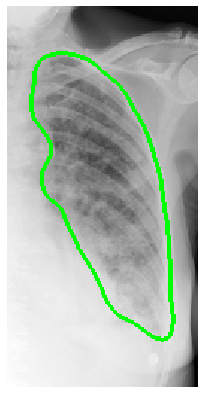

In [6]:
# --- Show the first example, msk
xs, ys = next(gen_train)
imshow(xs['dat'][0], xs['msk'][0], radius=3)

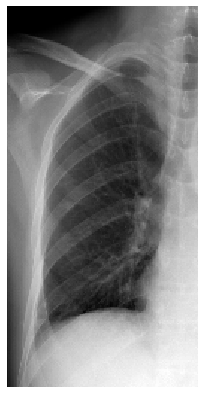

In [7]:
# --- Show the first example, pna
xs, ys = next(gen_train)
imshow(xs['dat'][0], ys['pna-seg'][0], radius=3)

Use the `imshow(...)` function to create an N x N mosaic of all images:

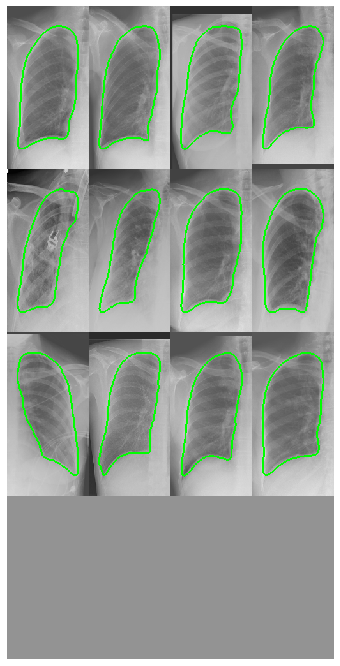

In [8]:
# --- Show "montage" of all images, msk
imshow(xs['dat'], xs['msk'], figsize=(12, 12), radius=3)

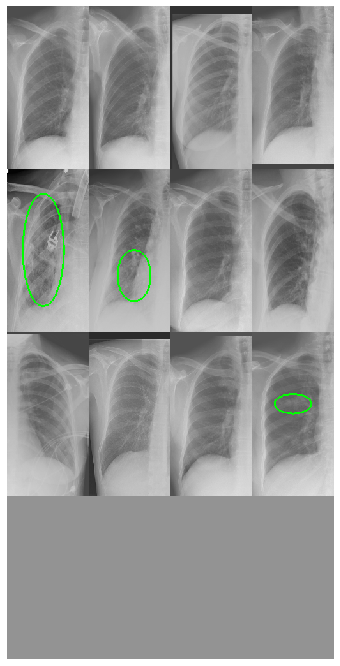

In [9]:
# --- Show "montage" of all images, pna
imshow(xs['dat'], ys['pna-seg'], figsize=(12, 12), radius=3)

### Model inputs

For every input in `xs`, a corresponding `Input(...)` variable can be created and returned in a `inputs` dictionary for ease of model development:

In [12]:
# --- Create model inputs
inputs = client.get_inputs(Input)

print(inputs.keys())
print(inputs['dat'].shape)
print(inputs['msk'].shape)

dict_keys(['dat', 'msk'])
(None, 1, 256, 128, 1)
(None, 1, 256, 128, 1)


# Model

The goal of this project is to perform **global classification** for each image. In other words, regardless of algorithm choice, the final objective is to determine the absence or presence of pneumonia for each sample. This does **not** mean that you are required to use classification networks only; in fact it very well may be the case that a localization algorithm will overall perform better on this task.

The task is designed to be open-ended on purpose. The only requirements are to:

* test at minimum three different network architectures
* one algorithm must use (at least) a classification type loss function
* one algorithm must use (at least) a segmentation type loss function

Note that the qualifier *at least* indicates that if you choose, you can use both classification and segmentation losses simultaneously for one algorithm to satisfy both requirements (this would allow you to test only non-classification / non-segmentation architectures for all remaining models if you choose).

While you can choose to be creative and employ any architecture that you like, the following discussion may help guide your development process.

### Classification

For your classifier, any architecture covered in class (or any novel architecture you wish to implement) can be used. Due to the relatively large dataset size, creative network topologies may be used.

**Important** Given that pneumonia infection can often be a very subtle finding, my recommendation is to use **more** convolutional layers (and filter channels) in the initial portion of your algorithm. These features in the early layers are going to represent fine details / high frequency patterns that are critical to good model performance. 

Assuming you are using the `lambda` notation described throughout class, then for example:

In [ ]:
# --- Define model with extra initial layers
l1 = conv1(32, conv1(32, inputs['dat']))
l2 = conv1(48, conv1(48, conv2(48, l1)))
l3 = conv1(64, conv1(64, conv2(64, l2)))

# ... and so on...

Feel free to experiment with various permutations. This recommendation to use extra parameters in the early layers will generally hold true for all model architectures below.

### Segmentation

Contracting-expanding architectures have many advantages over standard classification networks. Furthermore, to some extent, class imbalance has been mitigated by cropping the images to the right and left lungs individually. Thus, although lung masks have been provided (and likely may provide a slight incremental benefit over no masks), they are not required for this task.

Keep in mind that as stated above, we are not interested in the segmentation mask itself. Instead we want to eventually perform binary classification for all networks. To collapse a final segmentation mask into a binary prediction, consider that for the most part, negative exams will contain relatively smaller (or empty) masks while positive exams will contain larger masks. Thus the goal is to find a threshold for which differentiation may be optimized. Importantly keep in mind that this threshold should be determined based on the **training set** (not validation set), and then applied after to the test set.

To perform this task, first run inference through the train set to approximate the distribution of mask sizes between the two groups (pneumonia, no pneumonia). Given the large train set, it is not necessary to run through all cases (though for absolute highest precision this can be done):

In [ ]:
# --- Run model prediction for segmentation masks
test_train, test_valid = client.create_generators(test=True)

nnzs = []
true = []

for xs, ys in test_train:
    
    logs = model.predict(xs)
    pred = np.argmax(logs[1], axis=-1)
    
    # --- Remove masked pixels if needed
    pred[xs['msk'][..., 0] == 0] = 0
    
    # --- Record number of pixels in mask
    nnzs.append(np.count_nonzero(pred))
    true.append(ys['pna-cls'].squeeze())
    
    # --- Break after 1000 exams
    if len(nnzs) == 1000:
        break

# --- Convert to arrays
nnzs = np.array(nnzs)
true = np.array(true)

Now, to determine a threshold, start by comparing means as a good initial check:

In [ ]:
# --- Print mean of the two groups
print(nnzs[true == 0].mean())
print(nnzs[true == 1].mean())

Based on this, choose a threshold that seems reasonable.

In [ ]:
def calculate_accuracy(pred, true, treshold):
    """
    Method to calculate accuracy at given threshold of mask pixels
    
    """
    # --- Calculate true positives / true negatives
    tp = np.count_nonzero(nnzs[true == 1] >= threshold)
    tn = np.count_nonzero(nnzs[true == 0] < threshold)

    # --- Accuracy
    accuracy = (tp + tn) / nnzs.size
    
    return accuracy

print(calculate_accuracy(pred, true, 1000))

As course, as desired it may be reasonable to try a number of different thresholds.

### Box localization

For certain tasks, box localization networks may have advantages over segmentation architectures, primarily when dealing with class imbalance. Additionally the use of **focal** loss (which may be implemented in any architecture above) has an advantage to focus the algorithm on rare cases to further improve incremental model performance.

Should you decide to use a box localization algorithm, consider that the pneumonia lesions in general tend to be quite large (the images are already cropped to the right and left lungs). Thus ensure that the parameters for box configuration are adjusted appropriately. 